# Deep Learning & Applied AI

We recommend going through the notebook using Google Colaboratory.

# Tutorial 7: Uncertainty, regularization and the deep learning toolset

In this tutorial, we will cover:

- Uncertainty in deep learning
- Dropout and Batch normalization
- Deep Learning tools and code best practices

Based on original material by Dr. Luca Moschella, Dr. Antonio Norelli and Dr. Marco Fumero.

Course:

- Website and notebooks will be available at https://github.com/erodola/DLAI-s2-2024/

##Import dependencies (run the following cells)

In [17]:
!pip install plotly==5.3.1
!pip install numpy==1.23.0

In [18]:
# @title import dependencies

from typing import Mapping, Union, Optional

import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.graph_objects as go
import plotly.express as px
import torchvision
from torchvision import datasets, models, transforms

import os
import pickle
from tqdm.notebook import tqdm

from __future__ import print_function, division

In [19]:
# @title reproducibility stuff

import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)

torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False

# The Deep Learning Toolset

## Git


Git is an essential tool for any codebase.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/07/pics/xgit.png)

If you never used git or you want to make better use of it, w **highly recommend** to read at least the first three chapters (_Getting Started_, _Git Basics_, _Git Branching_) of this [book](https://git-scm.com/book/en/v2).

Some other useful resources:
- [Learn Git](https://www.atlassian.com/git/tutorials/what-is-version-control) by Atlassian is a great resource, alternative to the book.
- [Here](https://try.github.io/) there are great visualization tools to better understand the git tree

The important thing to grasp is the memory model of Git, don't try to memorize all its commands (which is hopeless and pointless). If you prefer a video tutorial, this one is a great [Deep Dive into Git](https://www.youtube.com/watch?v=xWHejdMuIMA) by Edward Thomson.

> Fundamentally, the Git command-line tools are a very thin layer of abstraction on top of its data model, so by understanding how Git works, you can better understand both how to use the command line and what to do when things go wrong.


### Git is not enough

Version control and multi-user collaboration are problems largely solved by git for classic codebases. Unfortunately, git alone is not enough to handle the lifecycle of a modern ML (research) project, where many different problems arise:

- **Data versioning**: can you recover the pre-processed data a model has been trained with? What if the data is a work in progress?

- **Hyperparameters comparison**: can you reliably say which hyperparameters are the best?

- **Model comparison**: can you identify which approach/model is the best?

- **Sweeps**: can you easily search for the best hyperparameters and models?

- **Code organization and reproducibility**: how steep is the codebase learning curve?

In DL, you have to tackle all the previous problems simultaneously!

## ML Tooling

Luckily many great tools have been developed to solve or alleviate these obstacles. Examples are *PyTorch Lightning* to organize your code, *DVC* for data versioning, *Weights & Biases* to compare and analyze your experiments, *Hydra* for configurations and sweeps, *Streamlit* to interact and showcase your system.



### Tooling Scaffolding

We [provide a template](https://grok-ai.github.io/nn-template) that you may choose to adopt in your project.
It provides boilerplate code for:

- [PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning), lightweight PyTorch wrapper for high-performance AI research.
- [Hydra](https://github.com/facebookresearch/hydra), a framework for elegantly configuring complex applications.
- [DVC](https://dvc.org/doc/start/data-versioning), track large files, directories, or ML models. Think "Git for data".
- [Weights and Biases](https://wandb.ai/home), organize and analyze machine learning experiments. *(educational account available)*
- [Streamlit](https://streamlit.io/), turns data scripts into shareable web apps in minutes.


The associated [documentation](https://grok-ai.github.io/nn-template) to the template contains [get-started](https://grok-ai.github.io/nn-template/latest/getting-started/generation/) and [features](https://grok-ai.github.io/nn-template/latest/features/nncore/) sections that may be particularly useful to start using it.



# Uncertainty in deep learning and two popular regularization techniques


In this section we will breafly discuss about *uncertainty* in deep learning, an inescapable concept whenever we aim to extrapolate a general rule from finite data.

We will also experiment with two popular *regularization* methods, dropout and batch normalization.

Surprisingly enough, these two arguments fit well in the same section, since a very effective and simple way to model uncertainty in deep learning is through dropout.

## Uncertainty in deep learning

> "*In almost all circumstances, and at all times,
we find ourselves in a state of uncertainty.*
>
>*Uncertainty in every sense.*
>
>*Uncertainty about actual situations, past and present (this might stem from either a lack of knowledge and information, or from the incompleteness and unreliability of the information at our disposal, either ours or someone else's, to provide a convincing recollection of these situations.) [...]*
>
>*Uncertainty in the face of decisions: more than ever in this case, compounded by the fact that decisions have to be based on knowledge of the actual situation, which is itself uncertain, to be guided by the prevision of uncontrollable events, and to aim for certain desirable effects of the decisions themselves, these also being uncertain.*"

>Bruno de Finetti *Theory of Probability: A critical introductory treatment*, Chapter 2

Despite representing model uncertainty in deep learning is of crucial importance -- think about medical applications or self-driving cars -- standard DNNs do not provide such information.

The $\pm$ symbol denoting the confidence interval of predictions is rare in deep learning papers, even if a prediction of a DNN on a test sample is everything except certain; uncertainty does not origin only in intrinsic stochastic processes (such as a radioactive decay or the roll of a dice), but *also when we have a lack of knowledge*, when we try to make a bet on something that is out of our ground truth, such as a test sample.

Notice that the probability interpretation of a softmax output does not solve the problem, **a model can be uncertain in its prediction even with a softmax output close to 1** as we will see.

Today we will explore a very simple idea to model uncertainty in deep learning through dropout, following the works of Gal and Ghahramani:
- [*Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning*](https://arxiv.org/abs/1506.02142)
-[*Bayesian Convolutional Neural Networks with Bernoulli Approximate Variational Inference*](https://arxiv.org/abs/1506.02158)

## Dropout and Batch Normalization; two common regularization methods

As seen in lecture, regularizers are general methods to reduce overfitting and thus improve generalization.

Regularization methods are based on general considerations about the learning algorithm, their ultimate objective is to reduce the number of free parameters.

Today we will experiment with
- **Dropout**: Training an ensemble of neural networks parametrizing each model by dropping random units from a single large network.
- **Batch Normalization**: Normalizing the activations of hidden layers as we do with the input data, allowing an easy learning of the identity function for the hidden layer.

### Reimplementing batchnorm

Before progressing any further, let's warm up by **re-implementing batch normalization** (the forward pass) from scratch. If you get this down, you'll easily understand all other normalization techniques! Recall from theory class that if you get a mini-batch $\mathcal{B}=\{\mathbf{x}_i\}$ of feature maps, the normalization to apply is:

$$ \mathbf{x}_i \mapsto \frac{\mathbf{x}_i - E[\mathcal{B}]}{\sigma(\mathcal{B})} $$

In [20]:
c = 2  # channels
w = 5  # width
h = 4  # height
b = 3  # feature maps

# prepare a random mini-batch
x = torch.arange(c*w*h*b, dtype=torch.float32).reshape((b, c, h, w))

# apply torch's batchnorm
BN = nn.BatchNorm2d(c)
y = BN(x)

> **EXERCISE:** Implement your own batchnorm and compare the resulting tensor with torch's result `y`. Only implement the forward pass: we don't care about the affine parameters $\beta$ and $\gamma$.

In [21]:
# ✏️ your code here

In [ ]:
# @title 👀 Solution

# compute the mean for each *entire* channel, i.e. over all the dimensions of all images in the batch.
# you get one scalar per channel.
mu = x.mean(dim=(0, 2, 3), keepdim=True)

# unbiased=False divides by N instead of N-1 (avoids Bessel's correction)
var = x.var(dim=(0, 2, 3), keepdim=True, unbiased=False)

# equivalent solution
# var = torch.sum((x - mu)**2, dim=(0, 2, 3), keepdim=True) / (w*h*b)

y_manual = (x - mu) / torch.sqrt(var + 1e-5)

torch.allclose(y, y_manual)

Now test your solution with this input tensor:

In [23]:
x = torch.rand((b, c, h, w))

> **EXERCISE:** If you run the comparison a few times when using the random `x`, do you always get the same results as torch? Try to understand what's going on.

In [24]:
# ✏️ your code here

In [ ]:
# @title 👀 Solution

# You don't always get the same results because of numerical error.
# You can make up for it by increasing the tolerance in the comparison:

print(torch.allclose(y, y_manual, atol=1e-6))  # instead of 1e-8

### Reimplementing dropout

Let's also **reimplement dropout** (just the forward pass)! Instead of zeroing out entire neurons as expected from the theory, what most implementations do is _zero out the features themselves_, in an element-wise fashion. In particular:

- _Fully-connected layers_: applying dropout to $\mathbf{Wx}$ means to zero out random rows of $\mathbf{W}$; this is akin to directly setting to zero random dimensions of $\mathbf{x}$, so most frameworks directly operate on $\mathbf{x}$.
- _Convolutional layers_: applying dropout still means zeroing out individual elements, but because of shared weights and spatial correlations, this can be thought of as randomly disabling certain features at various locations, rather than dropping entire feature maps. To specifically drop entire feature maps, **spatial dropout** is a variant used where entire channels (feature maps) are dropped; we'll use it later in the notebook.

So let's see it in action for a fully-connected layer:

In [ ]:
p = 0.8
inp = torch.ones(3, 7)

m = nn.Dropout(p=p)
out = m(inp)
out

Wait, what are those values? We entered a tensor of ones, and we got a tensor of fives.🤔

Here's what: Dropout is **rescaling the output by $\frac{1}{1-p}$** to compensate for the dropped elements. Without rescaling, dropout would lead to a mismatch in the activation scale during training and inference, which could harm the network's performance. Remember that dropout is typically disabled during inference (using `model.eval()` in PyTorch).

Mathematically, assume you have a tensor with $N$ elements, with mean $\mu$ _before_ dropout. When you apply dropout with probability $p$, you get that $(1-p)N$ elements remain, on average. Therefore:

$$E[\text{dropped}] = (1-p)\mu$$

At inference time, since dropout is not applied, all $N$ elements contribute to the output and their mean has the same scale as $\mu$. This is a different scale from what the network saw at training time!

To correct the discrepancy, we rescale the features during training to get:

$$ E[\text{rescaled}] = (1-p) \mu \cdot \frac{1}{1-p} = \mu $$

This ensures that the network behaves consistently across training and inference phases in terms of the scale of activations.

> **EXERCISE:** Implement the forward pass of dropout, and compare your result with PyTorch.

In [27]:
# ✏️ your code here

In [ ]:
# @title 👀 Solution

mask = torch.bernoulli(torch.ones_like(inp) * (1 - p)).bool()  # mask for zeroing-out elements with probability p
my_out = mask * inp / (1 - p)  # rescale by 1/(1-p)

inp.mean(), out.mean(), my_out.mean(), ((1-p)*my_out).mean()

## Training a bunch of models on CIFAR10

We are now ready to train several models on CIFAR10, experimenting with the effects of regularization and trying to say something about the uncertainty of our predictions.

Let's download and normalize the dataset...

In [ ]:
train_transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)


...and then prepare the dataloaders.

In [ ]:
batch_size = 32
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f'train set size: {len(trainset)}')
print(f'test set size: {len(testset)}')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)


As always we want to visualize some samples. Make your own prediction on each one.


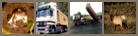

In [31]:
# @title Visualize samples

def visualize_samples(inputs, title=None):
    """
    Visualization of transformed samples, a standard call:
        inputs, classes = next(iter(dataloaders['train']))
        visualize_samples(inputs)
    Arguments:
    batch_of_samples -- a batch from the dataloader; a PyTorch tensor of shape (batch_size, 3, 224, 224)

    Return:
    None (A nice plot)
    """

    # Make a grid from batch
    inp = torchvision.utils.make_grid(inputs, nrow=12)

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  # plotly accepts colors both in the 0-1 range and in the 0-255 range
    fig = px.imshow(inp, title=title)
    fig.show()


# Get a batch of training data
inputs = [trainset[i][0] for i in range(4)]
class_idx = [trainset[i][1] for i in range(4)]  # ground-truth labels


visualize_samples(inputs, title=f'Make your prediction, what is the label of each image? The possible labels are<br> {[x for x in classes]}')

# Solution
# print(f'Ground truth: {[classes[x] for x in class_idx]}')

> **EXERCISE** Be conscious about your uncertainty on these predictions, how much would you bet on your guesses on each image?

For the purpose of our experiments we will work with a very simple CNN architecture, similar to the famous LeNet of 1998 by Yann Lecun, a time when there was no dropout nor batch normalization.

We will try 4 **+ 1** different models:
- LeNet  without dropout nor batch normalization (`VanillaLeNet`).
- LeNet with standard dropout after every fully connected layer (`StdDropoutLeNet`).
- LeNet with dropout2d (zeroing entire channels rather than individual units) after every convolutional layer, and standard dropout after every fully connected layer (`FullDropoutLeNet`).
- LeNet with batch normalization after every layer (`BatchNormLeNet`).





### SELU activation function

To be less boring than usual, today we will use **SELUs** (scaled exponential linear units); a rather exotic activation function from the crowded [zoo of activation functions](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions). If ReLU is the lion, SELU could be a platypus; seek its definition in the PyTorch documentation.

<img src="https://pytorch.org/docs/stable/_images/SELU.png" alt="drawing" width="400"/>

SELU was proposed in [*Self Normalizing Neural Networks*](https://arxiv.org/abs/1706.02515); it is supported by an ablation study on more than 100 machine learning tasks and a 90-page-long appendix full of calculations. The main point of SELUs is to induce self-normalizing properties without the necessity of batch normalization (!). This is of special interest for FNNs (fully connected networks) with many layers, which turn out to suffer from the perturbations induced by batch normalization.

### Network implementation

In [32]:
# We are not implementing the final softmax here, due to a future experiment

# LeNet without dropout
class VanillaLeNet(nn.Module):
    def __init__(self):
        super(VanillaLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 192, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(192, 192, 5, padding=2)
        self.fc1 = nn.Linear(192 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.selu(self.pool(self.conv1(x)))
        x = F.selu(self.pool(self.conv2(x)))
        x = x.view(-1, 192 * 8 * 8)
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = self.fc3(x)
        return x


# LeNet with dropout after fully connected layers
class StdDropoutLeNet(nn.Module):
    def __init__(self):
        super(StdDropoutLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 192, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(192, 192, 5, padding=2)
        self.fc1 = nn.Linear(192 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.selu(self.pool(self.conv1(x)))
        x = F.selu(self.pool(self.conv2(x)))
        x = x.view(-1, 192 * 8 * 8)
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(self.dropout(x)))
        x = self.fc3(self.dropout(x))
        return x


# LeNet with dropout also after convolutional layers
class FullDropoutLeNet(nn.Module):
    def __init__(self):
        super(FullDropoutLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 192, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(192, 192, 5, padding=2)
        self.fc1 = nn.Linear(192 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)
        self.dropout2d = nn.Dropout2d(p=0.3)

    def forward(self, x):
        x = F.selu(self.pool(self.dropout2d(self.conv1(x)))) # 2D dropout (drops entire channels)
        x = F.selu(self.pool(self.dropout2d(self.conv2(x))))
        x = x.view(-1, 192 * 8 * 8)
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(self.dropout(x)))
        x = self.fc3(self.dropout(x))
        return x


# LeNet with batch normalization
class BatchNormLeNet(nn.Module):
    def __init__(self):
        super(BatchNormLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 192, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(192)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(192, 192, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(192)
        self.fc1 = nn.Linear(192 * 8 * 8, 1024)
        self.bnf1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 256)
        self.bnf2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # Since we use batchnorm, we don't need SELU
        x = F.relu(self.pool(self.bn1(self.conv1(x))))
        x = F.relu(self.pool(self.bn2(self.conv2(x))))
        x = x.view(-1, 192 * 8 * 8)
        x = F.relu(self.bnf1(self.fc1(x)))
        x = F.relu(self.bnf2(self.fc2(x)))
        x = self.fc3(x)
        return x

Note that in `BatchNormLeNet`, we use `nn.BatchNorm1d` to deal with flattened feature maps, namely the outputs of linear layers. This function expects inputs of size $N\times C\times L$ rather than $N\times C\times H \times W$, but works exactly in the same way.

#### Monte Carlo dropout

Where's the **+ 1** model?

Here it is:

- LeNet with **Monte Carlo dropout** (`MonteCarloDropoutLeNet`), with the very same architecture of `FullDropoutLeNet` during training, but different at test time: _we keep zeroing out neurons even at inference time_, thereby collecting several predictions of the same samples and then taking their average. This is much closer to a classical ensemble method, since the same test sample is fed into *different models of the dropout ensemble*. This will also allow us to reason about the uncertainty of the prediction.

Let's define two functions to wrap up the training and test pipelines. The test function should take into account the different test modality of `MonteCarloDropoutLeNet`.

In [33]:
# We want to print the training loss every log_freq batches
log_freq = len(trainset)//batch_size  # default

def train(epoch, net, optimizer, loss_func, log_freq=log_freq):
    running_loss = 0.0
    for i, data in enumerate(trainloader, start=1):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i) % log_freq == 0:    # print every log_freq mini-batches
            print('[Epoch : %d, Iter: %5d] loss: %.3f' %
                  (epoch + 1, i, running_loss / log_freq))
            running_loss = 0.0
    return running_loss / log_freq

def test(net, is_MCDO=False, train_data=False):  # MCDO means Monte Carlo Drop Out
    if train_data:
        print("Accuracy on training data")
        dataloader = trainloader
    else:
        print("Accuracy on test data")
        dataloader = testloader
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            if batch_idx == len(testloader):
                break
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            output = 0
            if not is_MCDO:
                output = net(inputs)
            else:
                for i in range(20):  # aggregate over an ensemble of size 20
                    output += F.softmax(net(inputs), dim=1) / 20.
                output = torch.log(output)
            _, predicted = torch.max(output, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %.2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

    test_score = np.mean([100 * class_correct[i] / class_total[i] for i in range(10)])
    print(test_score)
    return test_score

>⚠️ **WARNING** The following cell will start the training of the models, it will take about 1 hour and 30 minutes (...with a GPU). You can go over it without training, the next section (_Experimenting with uncertainty_) will load a pretrained model.

Each model is saved in the `SAVE_PATH` at the end of its training, if you want to store the trained models beyond any *Colab Runtime disconnected* you can mount your Google Drive and set `SAVE_PATH` inside your drive. To mount your Drive open the Files menu on the left (Folder icon).

> **EXERCISE** (_Optional_, uses the Deep Learning Toolset) Monitor this training using a visualization toolkit of your choice or reimplement all the code using the nn-template.

> Are the weights of the dropout models closer to zero?  


In [ ]:
from tqdm.notebook import tqdm

run_training = False  #@param {type:"boolean"}
SAVE_PATH = '/content/'  #@param {type:"string"}

# the architecture of MonteCarloDropoutLeNet is the same of FullDropoutLeNet
lenets = [FullDropoutLeNet, StdDropoutLeNet, VanillaLeNet, BatchNormLeNet]

epoch_num = 75
test_freq = 5
losses = []
net_scores = {lenet.__name__ : [] for lenet in lenets}
net_scores['MonteCarloDropoutLeNet'] = []
net_tr_scores = {lenet.__name__ : [] for lenet in lenets}
net_tr_scores['MonteCarloDropoutLeNet'] = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if run_training:
    for lenet in lenets:
        print(lenet.__name__, 'training')
        net = lenet()
        net.to(device)

        learning_rate = 5e-4
        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0005, amsgrad=True)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.75)

        for i in tqdm(range(epoch_num)):
            net.train()
            loss_avg = train(epoch=i, net=net, optimizer=optimizer, loss_func=loss_func)
            losses.append(loss_avg)
            scheduler.step()

            if (i+1) % test_freq == 0:
                if lenet.__name__ == 'FullDropoutLeNet':
                    print('FullDropoutLeNet TEST')
                    net.eval()
                    net_score = test(net)
                    net_scores['FullDropoutLeNet'].append(net_score)
                    net_tr_score = test(net, train_data=True)
                    net_tr_scores['FullDropoutLeNet'].append(net_tr_score)
                    print('MonteCarloDropoutLeNet TEST')
                    net.train()
                    net_score = test(net,is_MCDO=True)
                    net_scores['MonteCarloDropoutLeNet'].append(net_score)
                    net_tr_score = test(net, is_MCDO=True, train_data=True)
                    net_tr_scores['MonteCarloDropoutLeNet'].append(net_tr_score)
                else:
                    net.eval()
                    net_score = test(net)
                    net_scores[lenet.__name__].append(net_score)
                    net_tr_score = test(net, train_data=True)
                    net_tr_scores[lenet.__name__].append(net_tr_score)
        torch.save(net.state_dict(), SAVE_PATH + lenet.__name__ + '.pt')



Finally we can look at the trends of the accuracy on seen and unseen data during training. What considerations can you make looking at the plot? What can be the causes of these trends?


In [ ]:
#@title Accuracy across epochs
fig = go.Figure()
for lenet_name, lenet_score in net_scores.items():
    x = np.arange(len(lenet_score))
    fig.add_trace(go.Scatter(x=x, y=lenet_score, mode='lines', name=lenet_name + ' test'))
for lenet_name, lenet_score in net_tr_scores.items():
    x = np.arange(len(lenet_score))
    fig.add_trace(go.Scatter(x=x, y=lenet_score, mode='lines', name=lenet_name + ' train'))

fig.update_layout(
        title='Accuracy across epochs',
        xaxis_title="epoch / test frequency",
        yaxis_title="Accuracy")

fig.show()
print(f'test frequency: {test_freq}')

**SPOILER** (make your own considerations before reading over)

Before any comparison between models, we notice a strong memorization; not only the accuracy on training data is much higher than the one on test data, but also reaching 100% is suspicious. In all likelihood the models have memorized the labels of some training samples. After all, the size of the training set is very limited for this kind of problem.

Concerning the two regularizers (batchnorm and dropout), both of them improved the results of the vanilla architecture, with batchnorm performing slightly better than dropout.

> **EXERCISE [A]** After these results a bunch of questions arise.
- Can we mitigate the memorization effect by augmenting the training dataset with some transformations?
- What happens if we increase the dropout probability? And if we apply dropout also on the input layer?
- What is the performance of a model with both batch normalization and dropout? In what order would you place them?
- Does the performance of `MonteCarloDropoutLeNet` increase if we rise the number of predictions from 20 to 50 or 100?
>
> Have a look at the accompanying [GitHub issue](https://github.com/erodola/DLAI-s2-2022/issues/21) from your colleagues in 2022!

### Experimenting with uncertainty

In this section we will see first-hand the ensemble behind a single neural net trained with dropout, looking closer at the predictions of each model in the ensemble.

First of all we load a pretrained `MonteCarloDropoutLeNet`.

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-0HX-AriuL8JOmknPHPvWgjdFfDhmSCx' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-0HX-AriuL8JOmknPHPvWgjdFfDhmSCx" -O MonteCarloDropoutLeNet.pt && rm -rf /tmp/cookies.txt

In [44]:
model = FullDropoutLeNet()
model.load_state_dict(torch.load('/content/MonteCarloDropoutLeNet.pt', map_location=device))
model = model.to(device)

In [45]:
# WARNING: very slow on CPU
# model.train()
test(model, is_MCDO=True)

Accuracy on test data
Accuracy of plane : 81.50 %
Accuracy of   car : 88.90 %
Accuracy of  bird : 69.00 %
Accuracy of   cat : 55.80 %
Accuracy of  deer : 71.80 %
Accuracy of   dog : 72.10 %
Accuracy of  frog : 85.60 %
Accuracy of horse : 83.60 %
Accuracy of  ship : 87.50 %
Accuracy of truck : 85.10 %
78.09


78.09

Since we want to test the uncertainty of the predictions of our model, we want to craft a difficult classification task.  
Let's find two test samples that are visually similar, but actually belong to different classes.


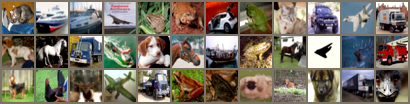

In [46]:
inputs = [testset[i][0] for i in range(36)]
class_idx = [testset[i][1] for i in range(36)]

visualize_samples(inputs)

What about the dog and the horse at the beginnning of the second line?

If we flip the horse horizontally they are even closer. Let's prepare a smooth transition between the two images in 12 steps, we are going to analyze the predictions of our model on each of these.


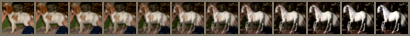

In [47]:
inputs_or = [testset[12][0], torch.flip(testset[13][0], dims=[2])]  #flip on dimension 2 to flip horizontally
inputs = [inputs_or[0] * (1 - i) + inputs_or[1] * i for i in np.linspace(0,1,num=12)]
visualize_samples(inputs)

Let's start looking at the labels predicted on each of these images by `MonteCarloDropoutLeNet`, averaging over 100 predictions.

Monte Carlo Dropout requires several predictions for the same sample to work, making tests more time consuming. Nevertheless we have GPUs (sometimes), and we can place copies of the same sample in a batch. As long as the batch fits in the GPU memory we can make these multiple predictions without slowdowns.

> **EXERCISE** Parallelize the following code to remove the second `for` loop. Can you parallelize it even more, removing also the first `for` loop?

In [48]:
model.train()
with torch.no_grad():
    for i, sample in enumerate(inputs):
        sample = sample.to(device)
        output = torch.zeros(10, device=device)

        for j in range(100):  # ensemble size is 100
            single_output = model(sample.unsqueeze(0))
            output += single_output[0] / 100.

        class_index = torch.argmax(output).item()
        print(i, classes[class_index])


0 dog
1 dog
2 dog
3 dog
4 dog
5 dog
6 horse
7 horse
8 horse
9 horse
10 horse
11 horse


In [49]:
# @title Solution 👀
model.train()
with torch.no_grad():
    for i, sample in enumerate(inputs):
        sample = sample.to(device)
        sample = sample.repeat(100, 1, 1, 1)
        outputs = model(sample)
        output = torch.einsum('il -> l', F.softmax(outputs, dim=1) / 100.)
        class_index = torch.argmax(output).item()
        print(i, classes[class_index])

0 dog
1 dog
2 dog
3 dog
4 dog
5 dog
6 horse
7 horse
8 horse
9 horse
10 horse
11 horse


Finally, let's analyze the final layer's activation distributions for the "dog" and "horse" classes, before and after applying the softmax. This will reveal how the raw and normalized activations for these specific classes compare.

In [50]:
model.train()
all_outputs = []
all_soft_outputs = []
with torch.no_grad():
    for sample in inputs:
        sample = sample.to(device)
        sample = sample.repeat(100, 1, 1, 1)
        outputs = model(sample)
        soft_outputs = F.softmax(outputs, dim=1)
        all_outputs.append(outputs.to('cpu').numpy())
        all_soft_outputs.append(soft_outputs.to('cpu').numpy())

Let's make a nice plot:


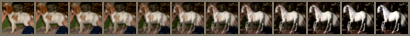

In [51]:
visualize_samples(inputs)
for k, output_sequence in enumerate([all_outputs, all_soft_outputs]):
    if k == 0:
        title = 'neuron outputs for dog and horse of the last layer BEFORE softmax (100 forward passes with dropout)'
    else:
        title = 'neuron outputs for dog and horse of the last layer AFTER softmax (100 forward passes with dropout)'
    fig = go.Figure()
    ndfp = output_sequence[0].shape[0]  # number of different forward passes
    x_dogs = np.zeros(len(output_sequence) * ndfp)
    y_dogs = np.zeros(len(output_sequence) * ndfp)
    x_horses = np.zeros(len(output_sequence) * ndfp)
    y_horses = np.zeros(len(output_sequence) * ndfp)
    for i, output in enumerate(output_sequence):
        x_dogs[i * ndfp: (i+1) * ndfp] += i
        y_dogs[i * ndfp: (i+1) * ndfp] = output[:,5]
        x_horses[i * ndfp: (i+1) * ndfp] += i
        y_horses[i * ndfp: (i+1) * ndfp] = output[:,7]

    fig.add_trace(go.Scatter(x=x_dogs, y=y_dogs,
                        mode='markers',
                        name='dogs',
                        marker=dict(
                            size=50,
                            opacity=0.1,
                            symbol='line-ew',
                            line=dict(width=6, color='deepskyblue'))))
    fig.add_trace(go.Scatter(x=x_horses, y=y_horses,
                        mode='markers',
                        name='horses',
                        marker=dict(
                            size=50,
                            opacity=0.1,
                            symbol='line-ew',
                            line=dict(width=6, color='salmon'))))
    fig.update_layout(
        title=title,
        xaxis_title="image",
        yaxis_title="neuron activation",
        xaxis_type='category')

    fig.show()


First of all let's look at the results on the central images (index 5-6) *before* the softmax, the more ambiguous ones. As expected, the activations of the dog and horse neurons are quite close; the distributions of these activations over the ensemble of models are overlapping, unlike the first and last images where the two distributions are well separated.

Look now at the activations *after* the softmax, despite the higher ambiguity of the central images, we have several models in the ensemble with the maximum activation of 1. It should be now clear that we can not attribute a 100% confidence to a classification based on a softmax close to one!

Instead, we can evaluate the **uncertainty** of our predictions by looking at the **overlap of the distributions** of activations before the softmax.

> **EXERCISE [B]** Look at the distribution of activations on new images (even a combination of more than two, or maybe now taking two very different images, or instead very close, or with the same label, or...). Again, have a look at the accompanying [GitHub issue](https://github.com/erodola/DLAI-s2-2022/issues/21) from 2022 for stimulating discussions!